# Using the SEBA Algorithm together with Linear Response for the Double Gyre System (SEBA Part 1)

In the following, we want to know how we can use the SEBA partition together with an already computed linear response, in order to assess how the partitions change for varying parameter values. We start with the simple double gyre system to illustrate the basic ideas, and will show the application to the real world ocean data in another notebook. 

## Setup

In [1]:
include("../../src/CoherentStructures.jl")

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 200
quadrature_order       = 5
nev                    = 10        # number of eigenvectors
ϵ                      = 0.2       # perturbation
t₀                      = 0.6      # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

## Compute Eigenfunctions and Linear Response

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 30.476656 seconds (120.28 M allocations: 7.056 GiB, 5.36% gc time)


In [8]:
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ);

In [9]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

107.526966 seconds (148.02 M allocations: 13.713 GiB, 2.39% gc time)


In [10]:
normalizeUL2(u,M) = u.*sign.(sum(u))./ sqrt(u'*M*u);

In [11]:
# solve the eigenproblem
λ₀, u₀ = eigs(K, M, which=:SM, nev=nev)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀)
λ₀ = real.(λ₀)
for i in 1:size(u₀)[2]
    u₀[:,i] = normalizeUL2(u₀[:,i],M)
end

In [12]:
# calculate the exact uϵ
λϵ, uϵ = eigs(Kϵ, M, which=:SM, nev=nev)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ)
λϵ = real.(λϵ)
for i in 1:size(uϵ)[2]
    uϵ[:,i] = normalizeUL2(uϵ[:,i],M)
end

In [13]:
# solve the system for the derivative u_dot
u_dot = zero(u₀)
λ_dot = zero(λ₀)
for i in 1:size(u₀)[2] 
    u_dot[:,i], λ_dot[i] = getLinearResponse(u₀[:,i],λ₀[i],M,K,L)
end

## Some first plots

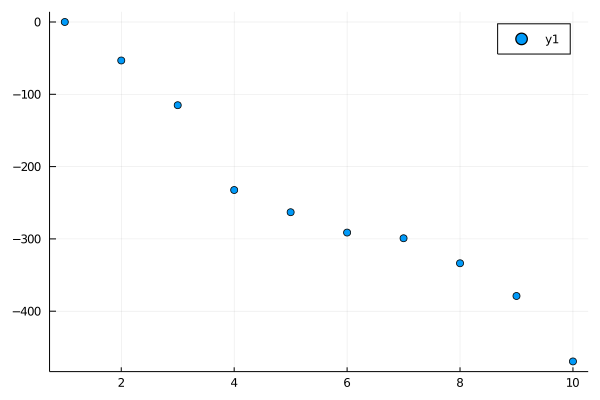

In [14]:
#select number of evs
Plots.scatter(1:nev,λ₀)

In [15]:
#Eigengap after 3 eigenvalues
nev = 3
u₀ = u₀[:,1:nev]
λ₀ = λ₀[1:nev]
uϵ = uϵ[:,1:nev]
λϵ = λϵ[1:nev]
u_dot = u_dot[:,1:nev]
λ_dot = λ_dot[1:nev];

In [16]:
for i in 2:nev
    print("exact ev"*string(i)*": "*string(λϵ[i])*
        "\t predicted ev"*string(i)*": "*string(λ₀[i] + ϵ*λ_dot[i])*
        "\t relative error: "*string(abs(λ₀[i] + ϵ*λ_dot[i] - λϵ[i])/abs(λϵ[i]))*"\n")
end

exact ev2: -68.15832552241685	 predicted ev2: -65.37712590707983	 relative error: 0.04080498741745492
exact ev3: -126.86198449821215	 predicted ev3: -126.91250541094857	 relative error: 0.000398235239155736


In [17]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmins =     [-2.5, -2.5, -2.5]
cmaxs =     -cmins
cmins_lr =  [-2.5, -2.5, -2.5]
cmaxs_lr =  -cmins_lr;

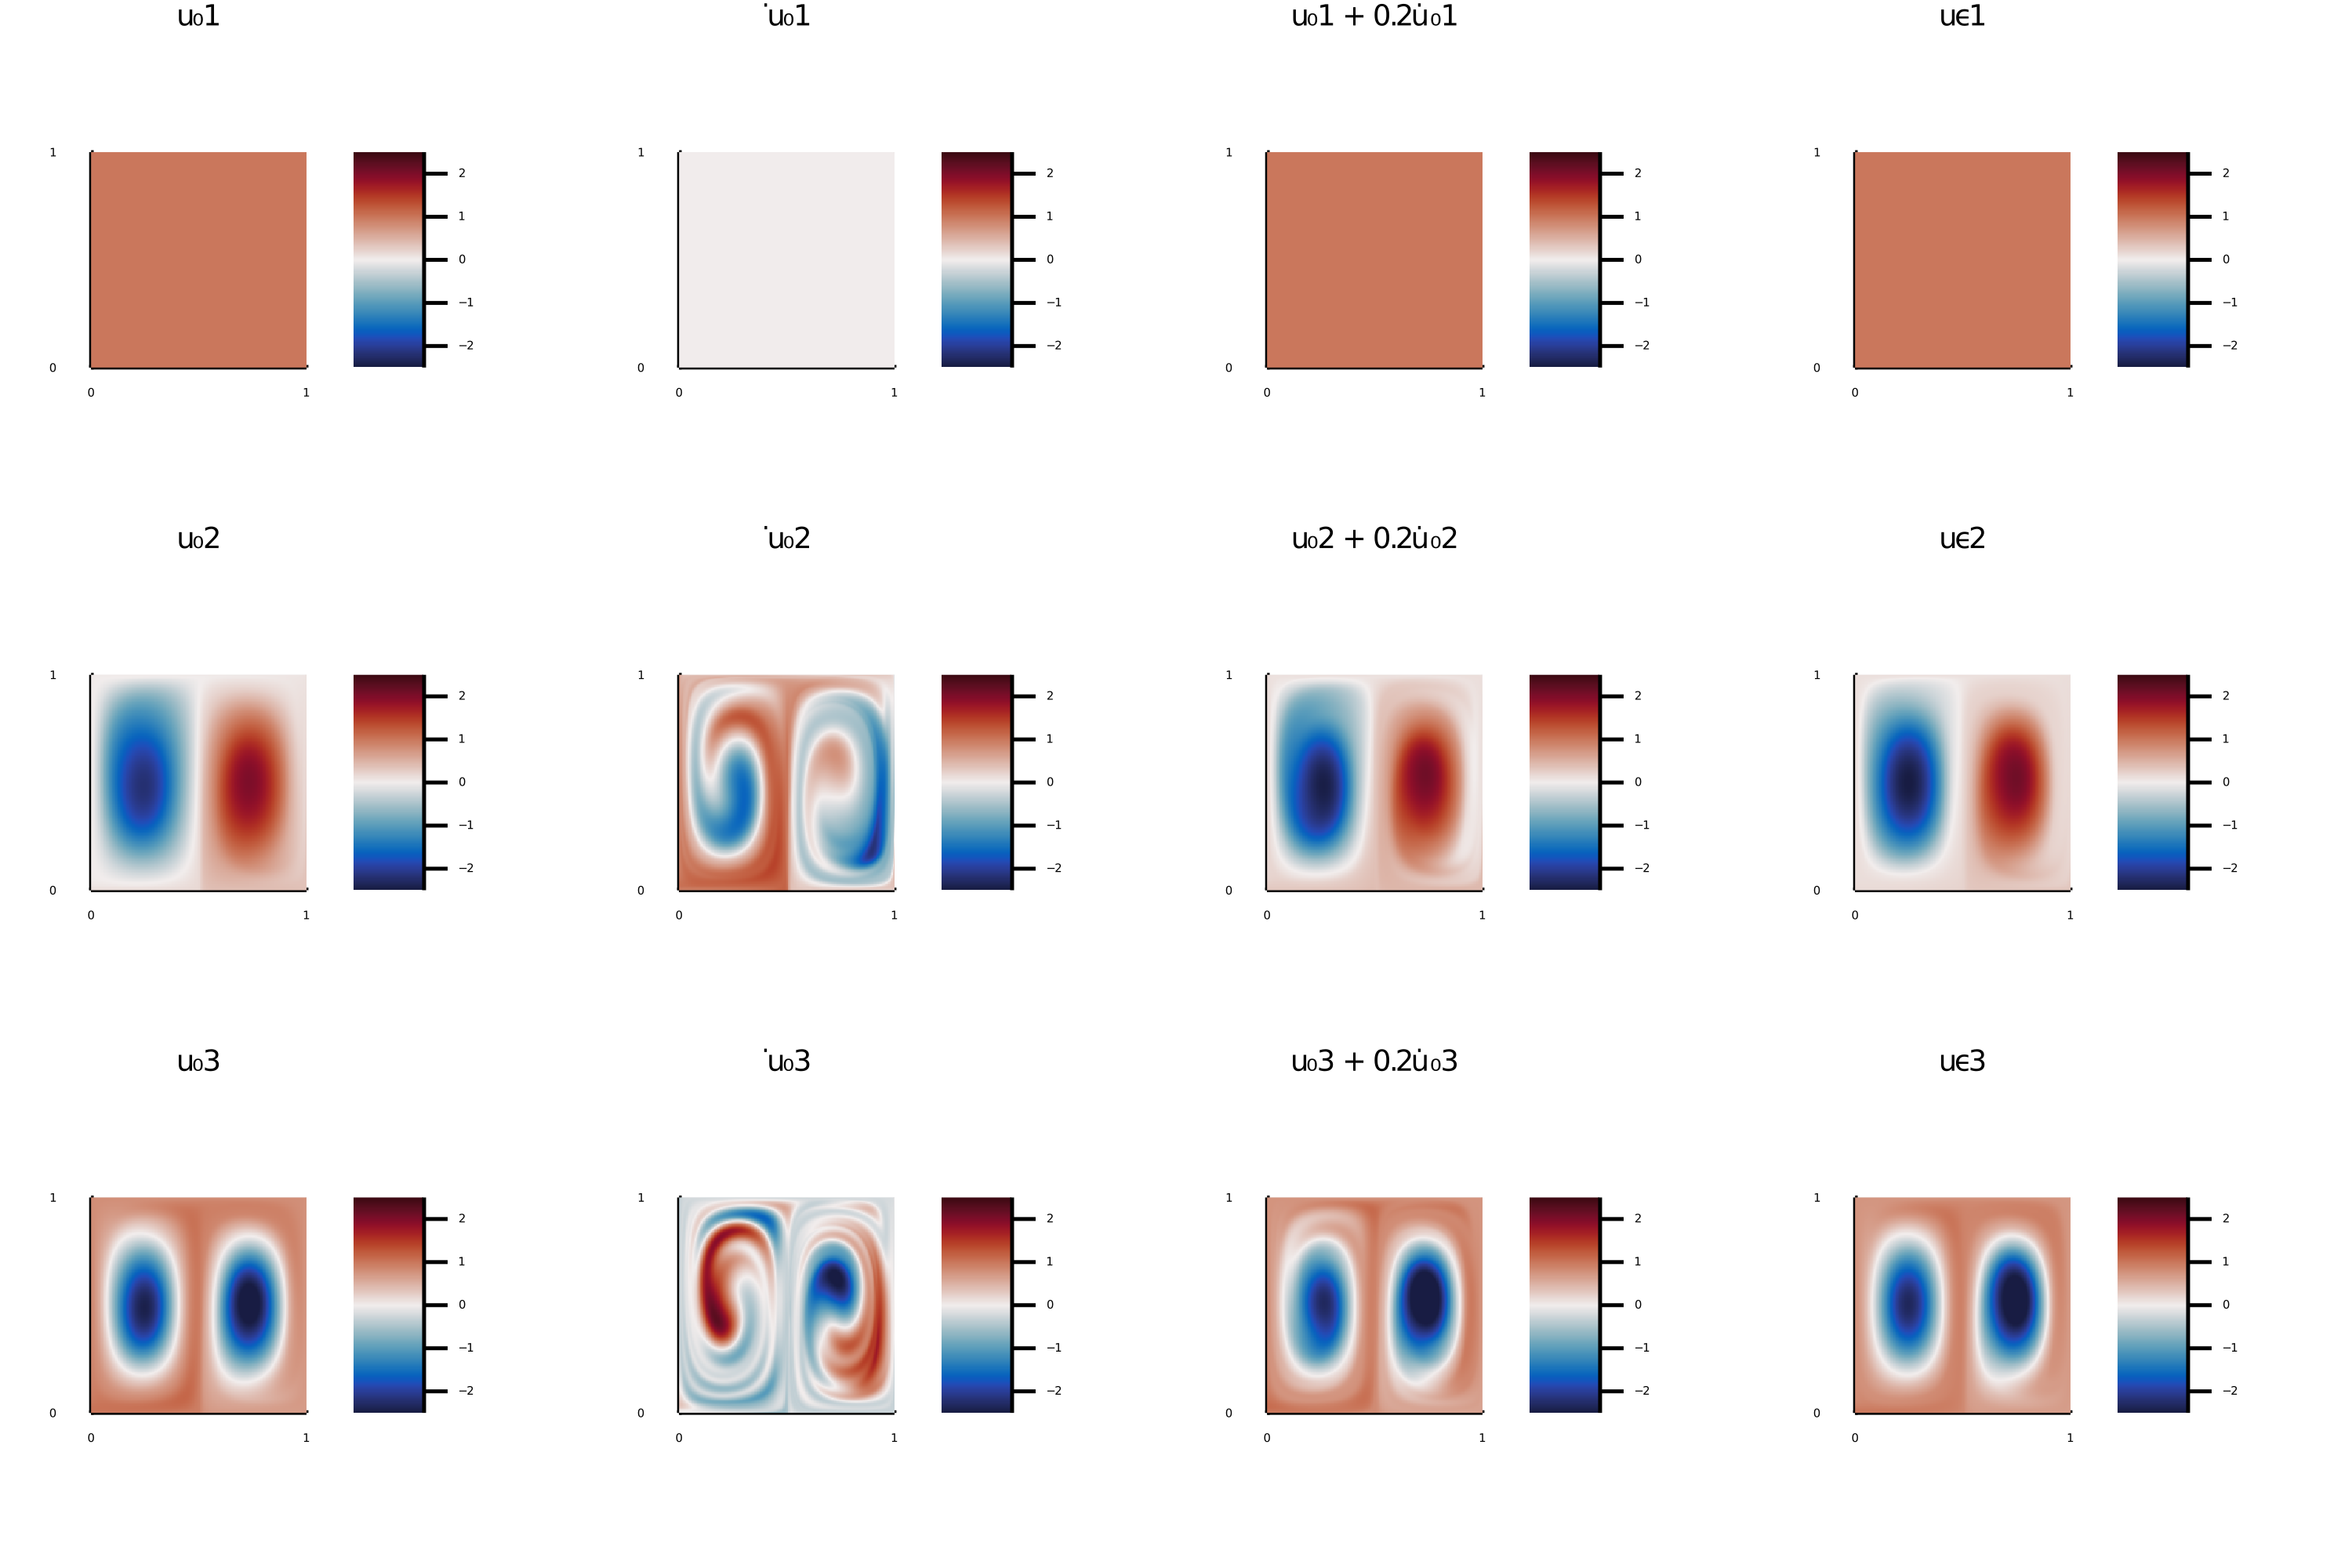

In [18]:
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, u₀[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i), 
                colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u_dot[:,i],  grid_resolution, grid_resolution, 
            title="̇u₀"*string(i), 
        colorbar=colorbar, color=color, clims=(cmins_lr[i],cmaxs_lr[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, u₀[:,i] + ϵ*u_dot[:,i],  grid_resolution, grid_resolution, 
            title="u₀"*string(i)*" + $(ϵ)u̇ ₀"*string(i), 
    colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, uϵ[:,i],  grid_resolution, grid_resolution, 
            title="uϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(cmins[i],cmaxs[i]), xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [19]:
#limit ourselves to one ev for plotting etc.
ev = 2

2

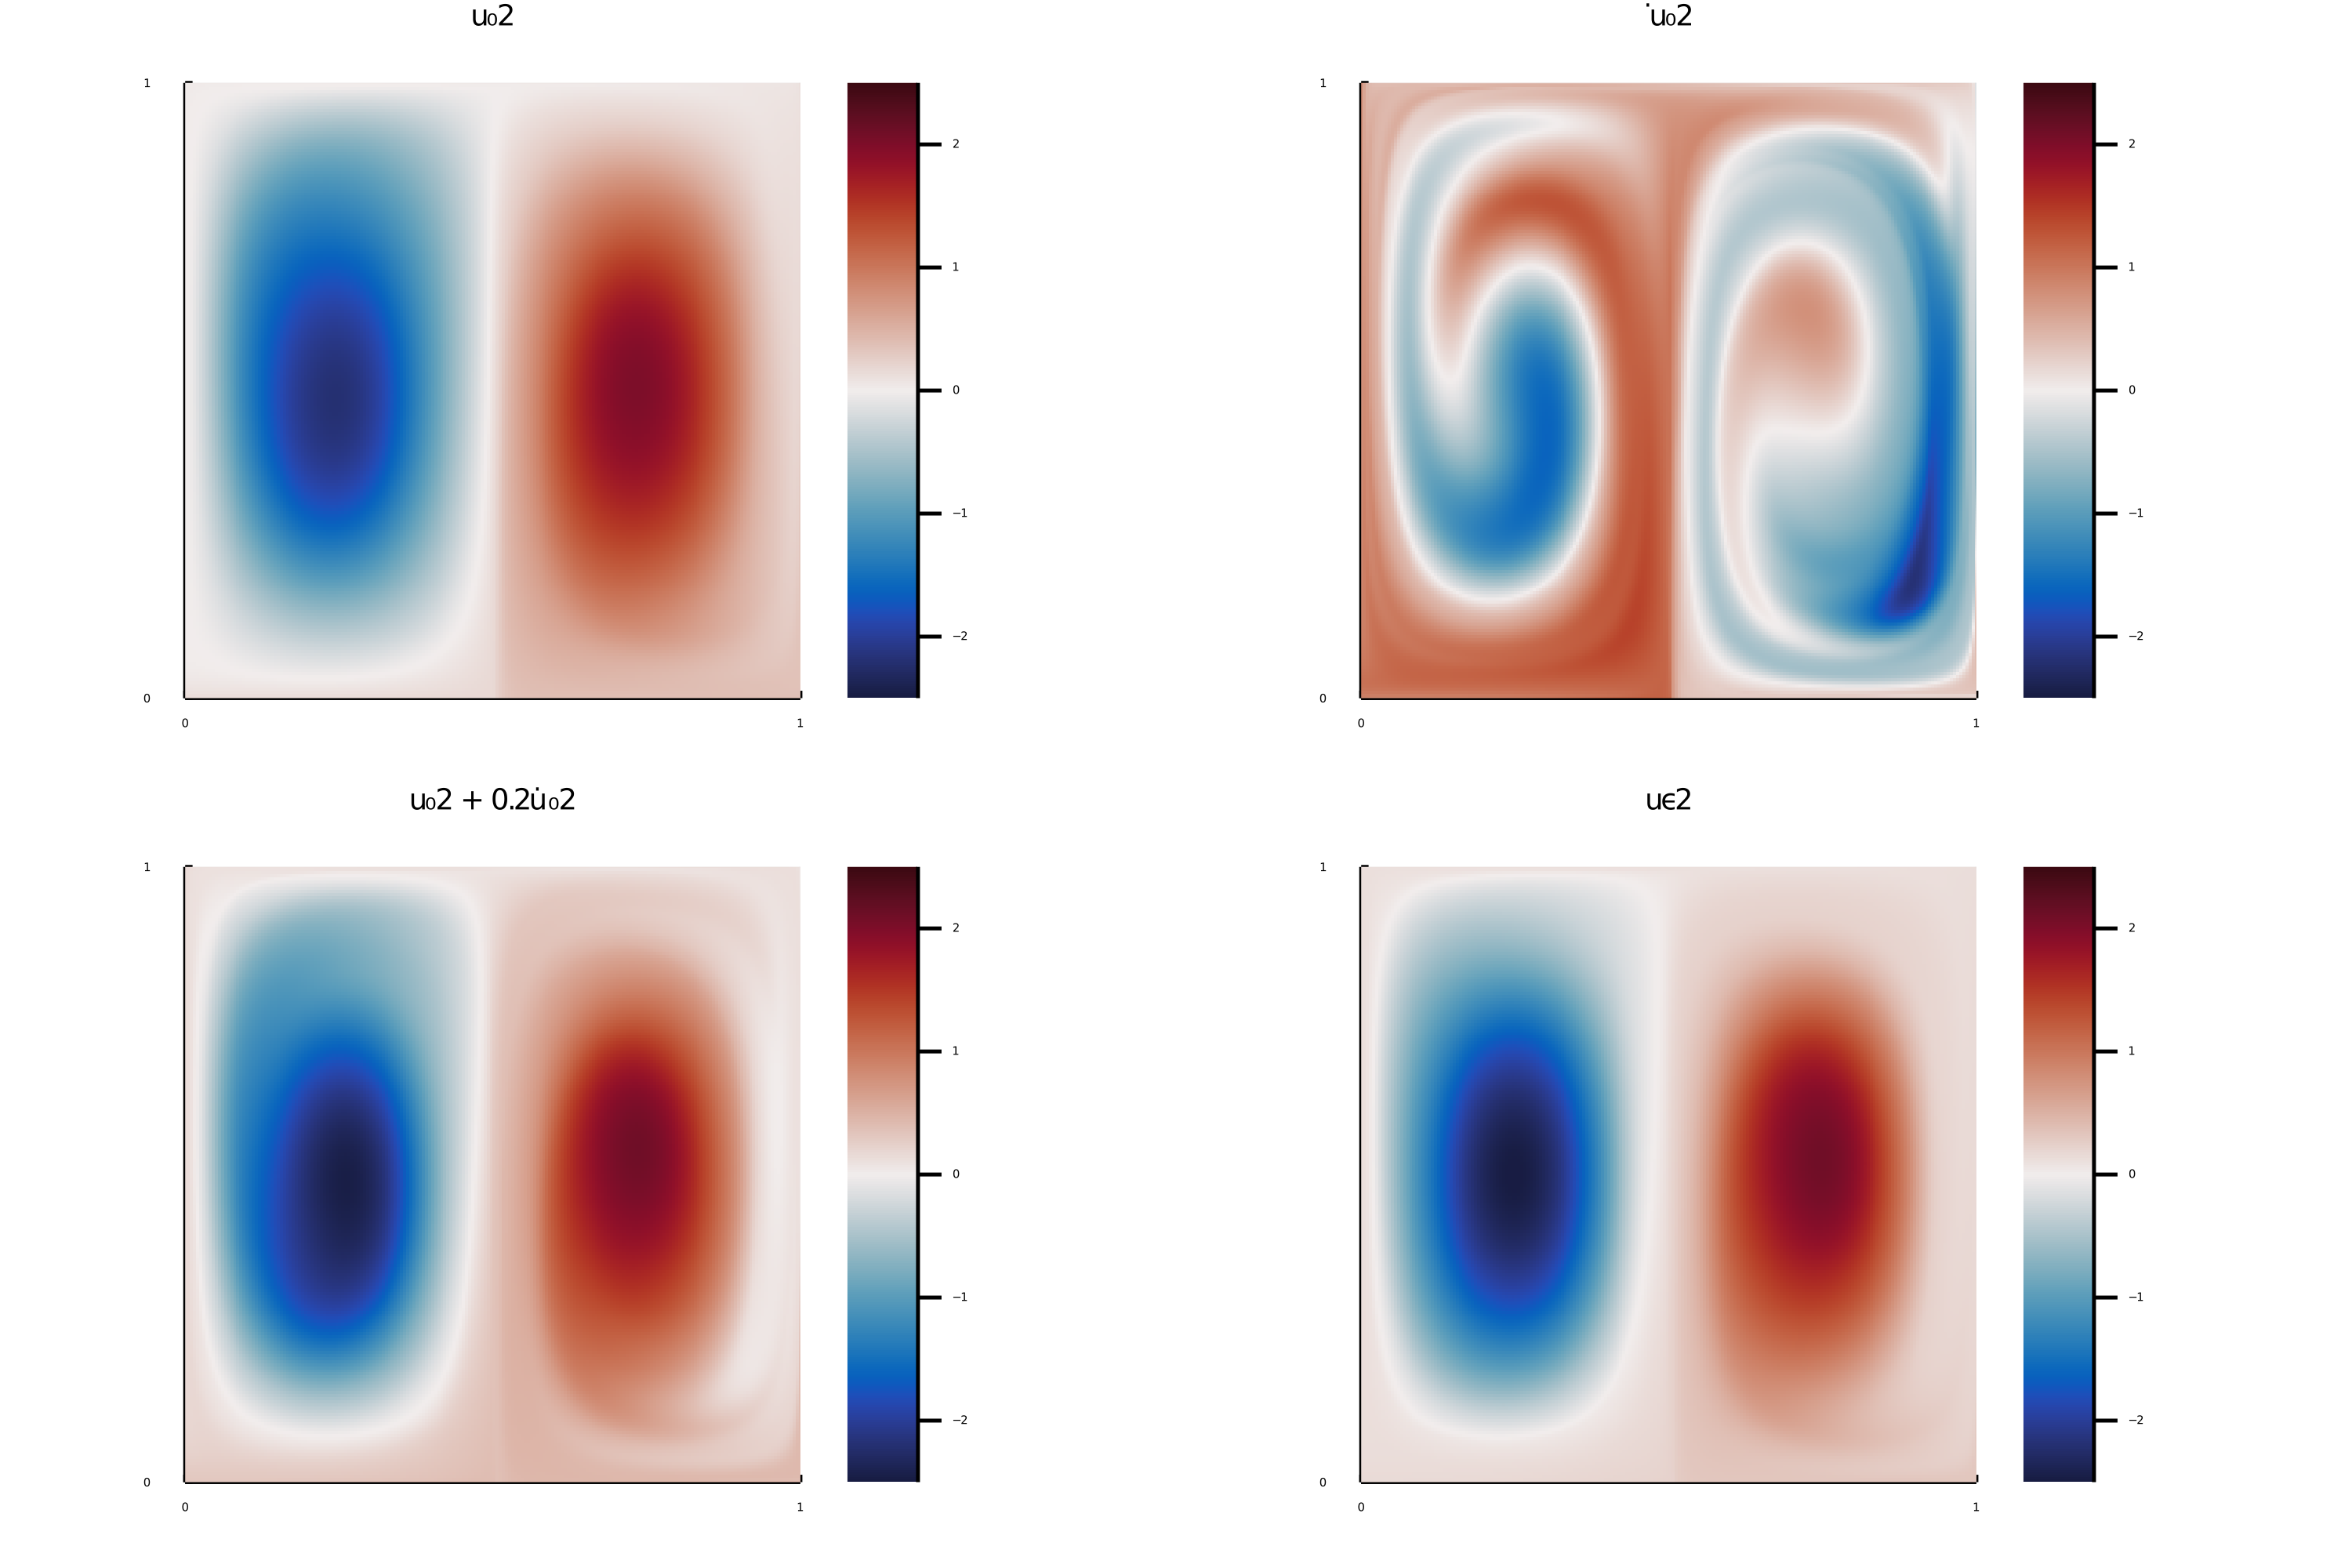

In [20]:
plots = []
push!(plots,plot_u(ctx, u₀[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev), 
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="̇u₀"*string(ev), 
    colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],  grid_resolution, grid_resolution, 
        title="u₀"*string(ev)*" + $(ϵ)u̇ ₀"*string(ev), 
colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, uϵ[:,ev],  grid_resolution, grid_resolution, 
        title="uϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=grid(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contour Plots

In [21]:
using Contour

In [22]:
import Main.CoherentStructures:dynamic_cheeger_value
dynamic_cheeger_value(c) = dynamic_cheeger_value(ctx,c,x->T(x,0);tolerance=1e-10)

dynamic_cheeger_value (generic function with 2 methods)

In [23]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀[:,ev],dynamic_cheeger_value,
    n_candidates=1000,min=0)

c_best = level(best_levelset)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",c_best,"\n")

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.030272932193471012)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.03229112767303575)
└ @ Main.CoherentStructures C:\Users\Martin\D_Drive\Uni\3 Mathematics in Data Science\05 Masterarbeit\CoherentStructures.jl\src\dynamicIsoperimetry.jl:155


Dynamic Cheeger value:	6.387396349575305
Levelset:		0.02421834575477681


In [24]:
using PyCall
using PyPlot

In [25]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

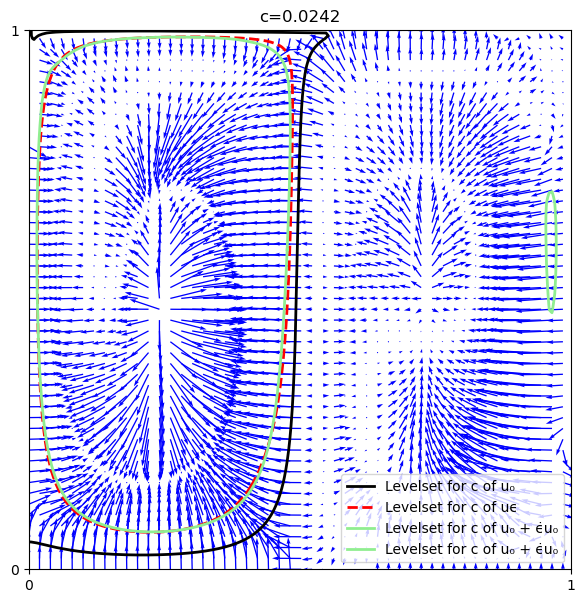

In [26]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀[:,ev],u_dot[:,ev])...,ax,scale=20,step=4)
curves           = lines(get_levelset(ctx, u₀[:,ev],c_best))
curves_epsilon   = lines(get_levelset(ctx, uϵ[:,ev],c_best))
curves_predicted = lines(get_levelset(ctx, u₀[:,ev] + ϵ*u_dot[:,ev],c_best))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2, label="Levelset for c of u₀")
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2, label="Levelset for c of uϵ")
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2, label="Levelset for c of u₀ + ϵ̇u₀")
end
ax.set_title("c=$(round(c_best,digits=4))")
ax.legend();

## SEBA

In [27]:
softThreshold(u,μ) = sign.(u) .* max.(abs.(u) .- μ, 0)
normalizeU(u) = u.*sign.(sum(u))/maximum(u*sign.(sum(u)))

normalizeU (generic function with 1 method)

We are now interested in the linear response of the partitions chosen by the SEBA algorithm. For this we note that 
1. If **U₀** is the matrix containing the initial Eigenfunctions, then, once converged, the algorithm returns a new set of functions **S** and an orthonormal matrix **O** such that, if **U₀** = **QR** is the QR decomposition, we have **S** = normalizeU(softThreshold(**U₀**(**R**^-1)**O**ᵀ,μ))
2. If **Udot** is the matrix containig the initial linear response of **U₀**, then for any matrix B we have that **UdotB** is the linear response of **U₀B** by linearity. 

In [28]:
using LinearAlgebra

In [29]:
# standard heuristic
μ = 0.99/grid_resolution;

In [30]:
@time S, O = SEBA(u₀,μ=μ,returnR=true,sort=false);

  1.675255 seconds (6.33 M allocations: 433.034 MiB, 7.05% gc time)


In [31]:
Sϵ, Oϵ = SEBA(uϵ,μ=μ,returnR=true,sort=false);

In [32]:
#The SEBA outputs, but without thresholding and rescaling, so that they are comparable to S_dot
S′ = Matrix(qr(u₀).Q)*O'
Sϵ′ = Matrix(qr(uϵ).Q)*Oϵ';

In [33]:
# This is the matrix we effectively multiply u₀ with
inv(qr(u₀).R)*O'

3×3 Array{Float64,2}:
 -0.00403375    0.00212895   0.00204894
 -0.000234302  -0.00371112   0.00337776
 -0.00291623   -0.00263361  -0.00310364

In [34]:
inv(qr(uϵ).R)*Oϵ'

3×3 Array{Float64,2}:
 -0.00409091    0.00210339   0.00196003
 -0.000408308  -0.00382516   0.00323082
 -0.00281837   -0.00248713  -0.00331088

In [35]:
S_dot = u_dot*inv(qr(u₀).R)*O';

In the following, there is another interesting point to be aware of: 

We are predicting **Uϵ**(**R**^-1)**O**ᵀ, where **R** and **O** come from (the SEBA algorithm applied to) **Udot**. What we are comparing it to, however, is **Uϵ**(**Rϵ**^-1)**Oϵ**ᵀ, so there is another source of error. Looking at the entries of both matrices above however, we can assume that the effect should not be too large.

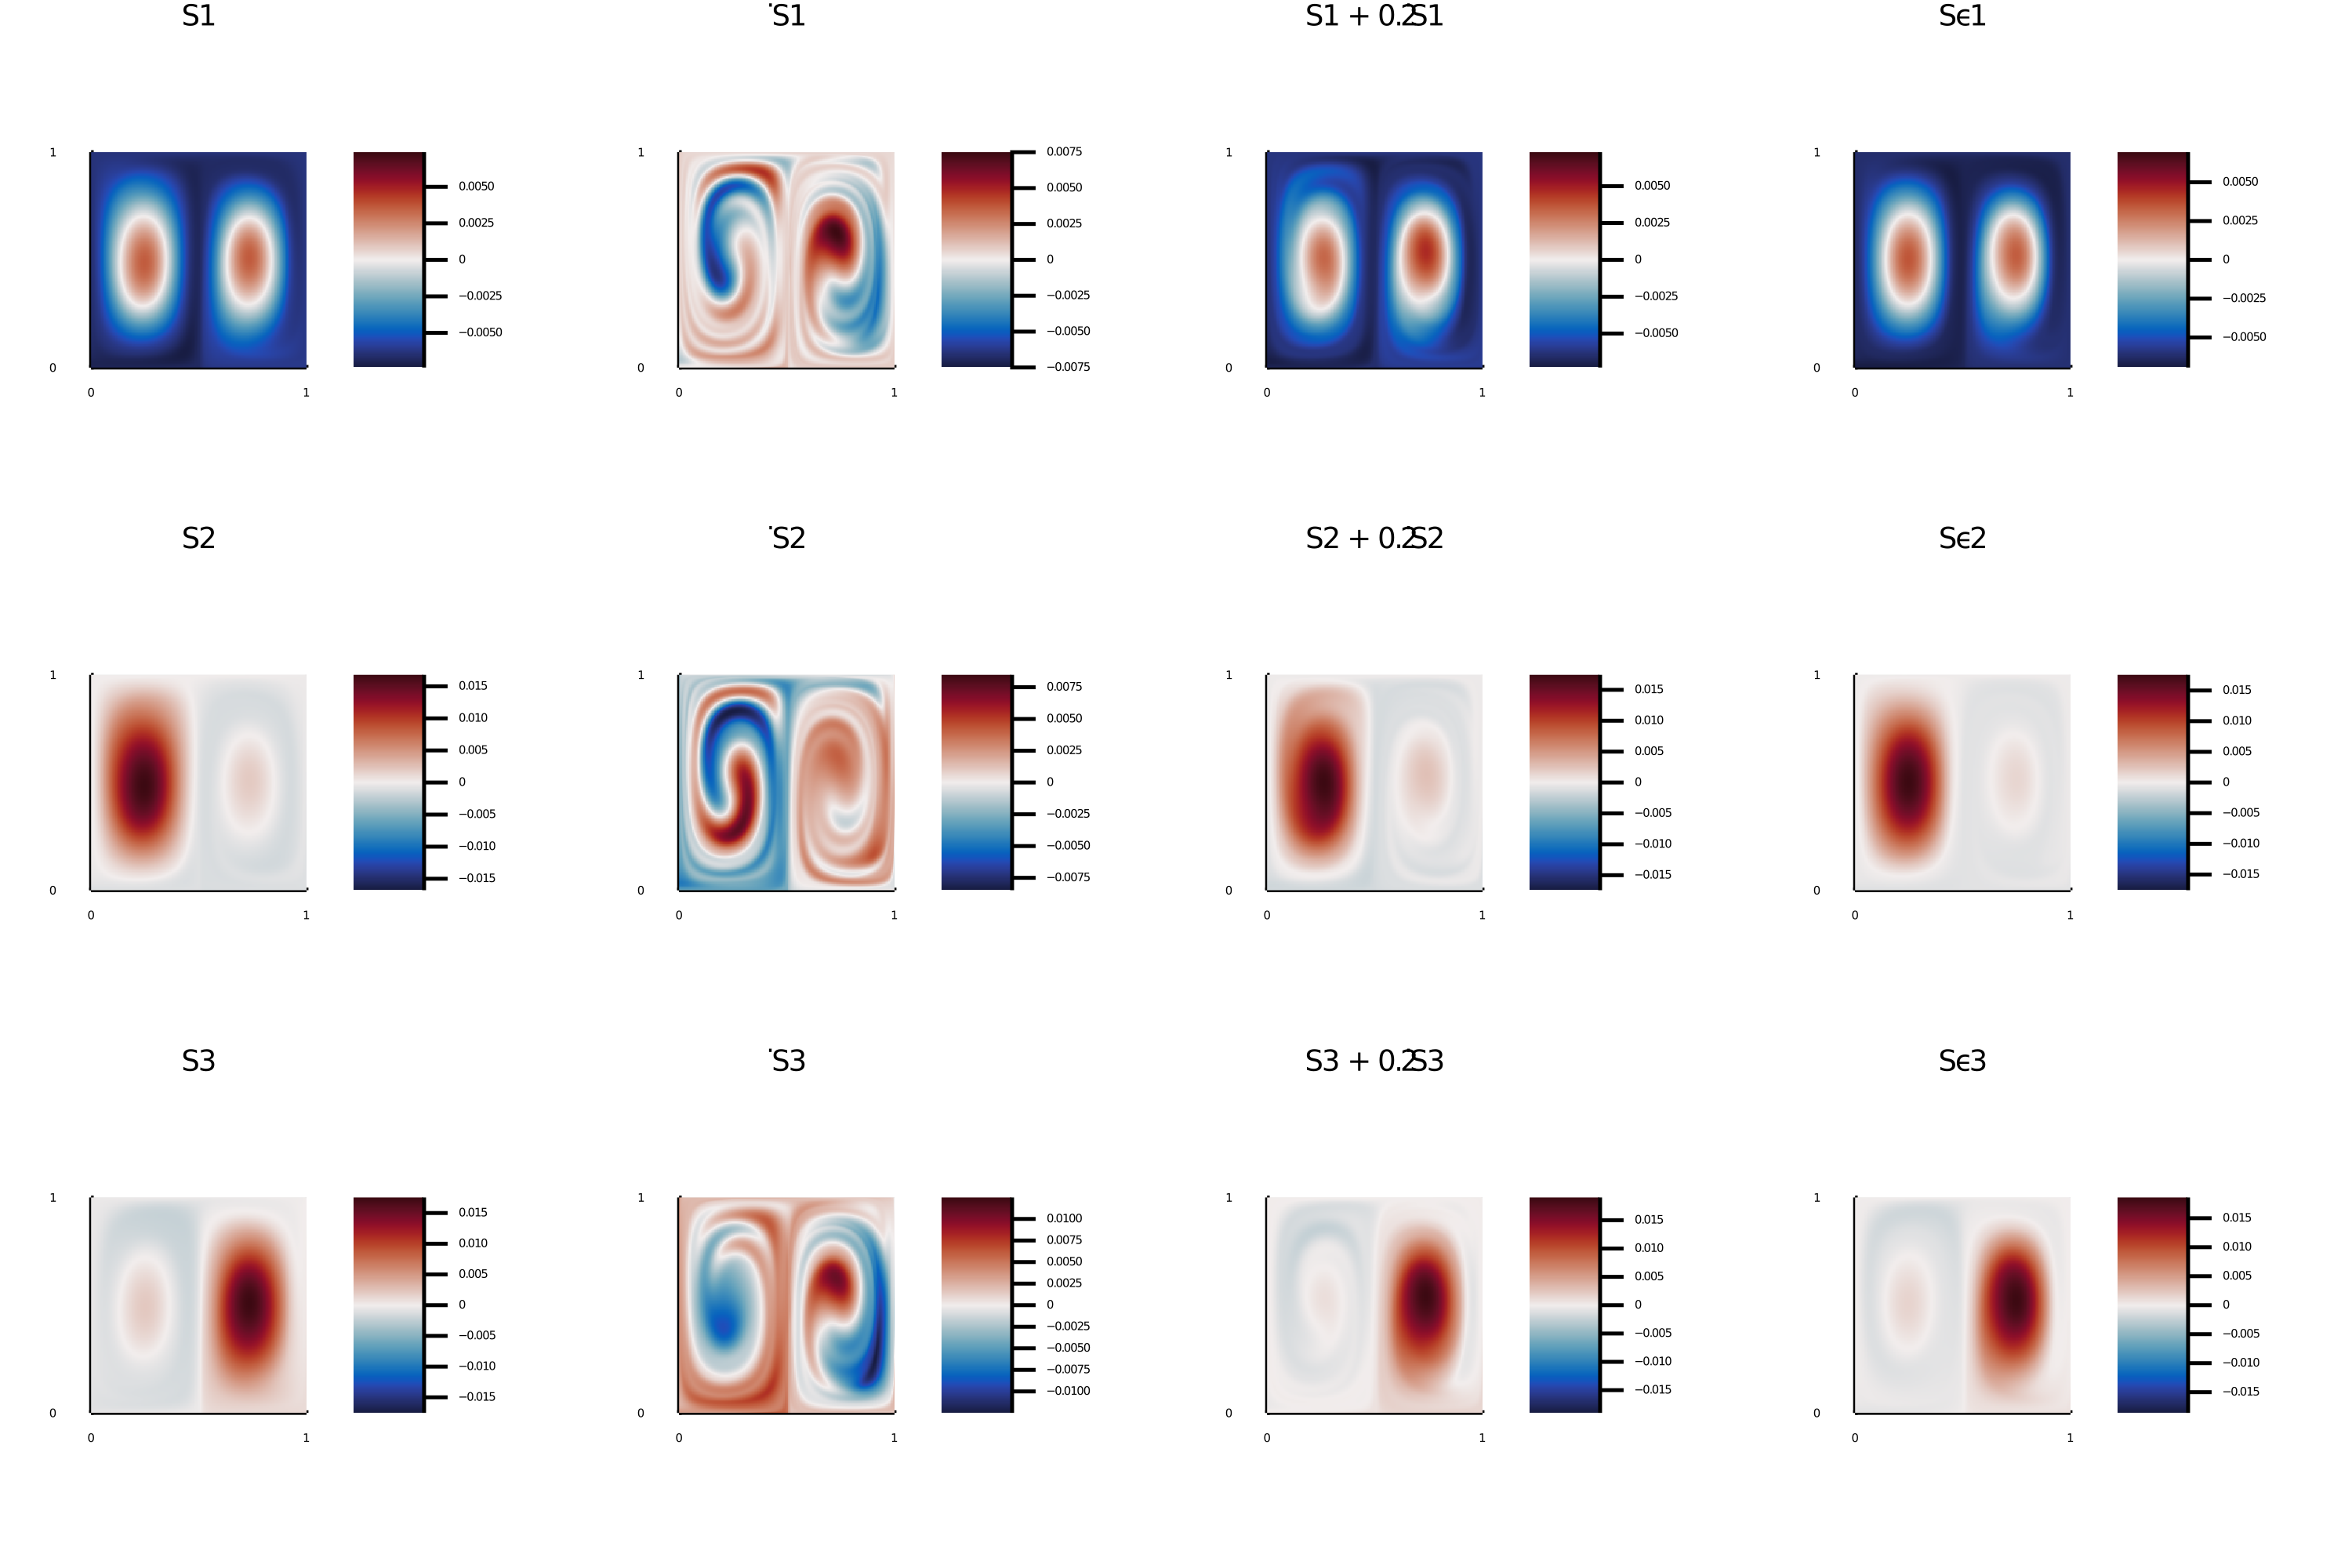

In [36]:
#for S′ and Sϵ′, we have a linear response, namely S_dot 
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S′[:,i],  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,i])),maximum(abs.(S′[:,i]))),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S_dot[:,i], 
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,i])),maximum(abs.(S_dot[:,i]))), 
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S′[:,i] + ϵ*S_dot[:,i],  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,i] + ϵ*S_dot[:,i])),maximum(abs.(S′[:,i] + ϵ*S_dot[:,i]))), 
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ′[:,i],  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(Sϵ′[:,i])),maximum(abs.(Sϵ′[:,i]))), 
            xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

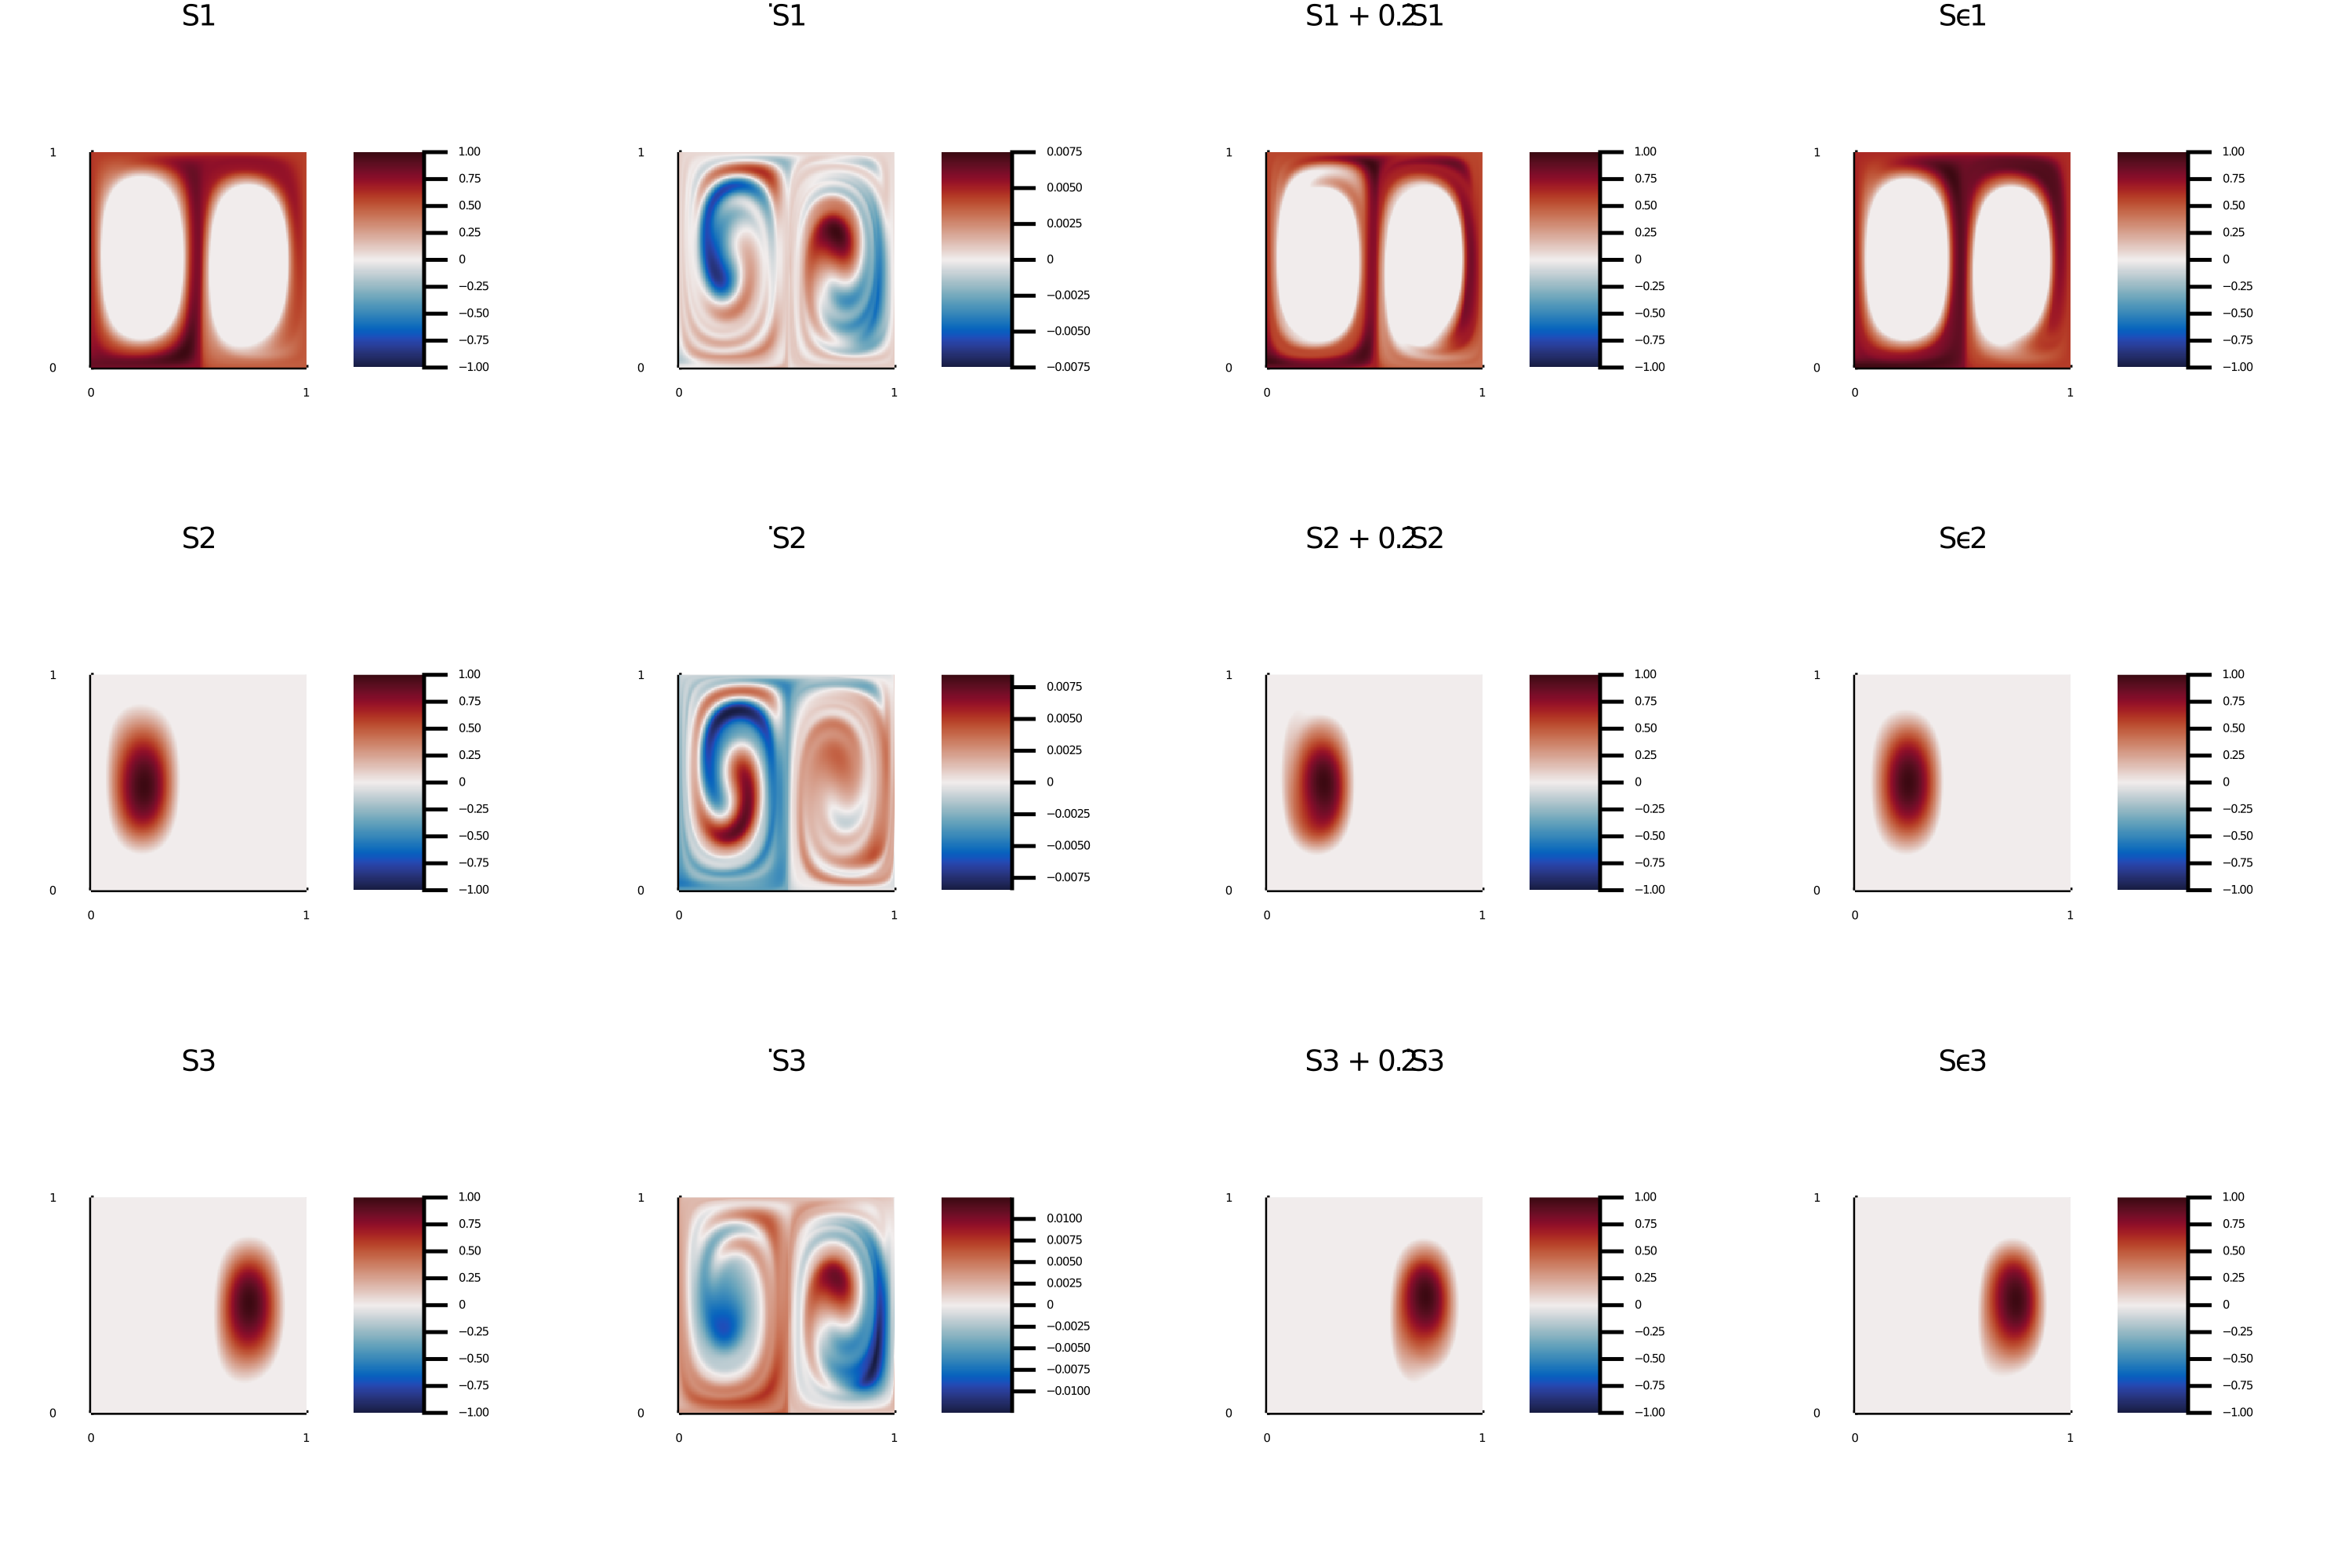

In [37]:
# to get a prediction for Sϵ from S and S_dot, we simply apply soft thresholding and normalization to the previous example
plots = []
for i in 1:nev
    push!(plots,plot_u(ctx, S[:,i],  
            grid_resolution, grid_resolution, 
            title="S"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, S_dot[:,i],  
            grid_resolution, grid_resolution, 
            title="̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,i])),maximum(abs.(S_dot[:,i]))),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,i] + ϵ*S_dot[:,i],μ)),  
            grid_resolution, grid_resolution, 
            title="S"*string(i)*" + $(ϵ)̇S"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
    push!(plots,plot_u(ctx, Sϵ[:,i],  
            grid_resolution, grid_resolution, 
            title="Sϵ"*string(i), 
            colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
end
Plots.plot(plots..., fmt=:png, dpi=500,layout=(nev,4),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

In [38]:
#again, select one index for closer inspection
ev = 2

2

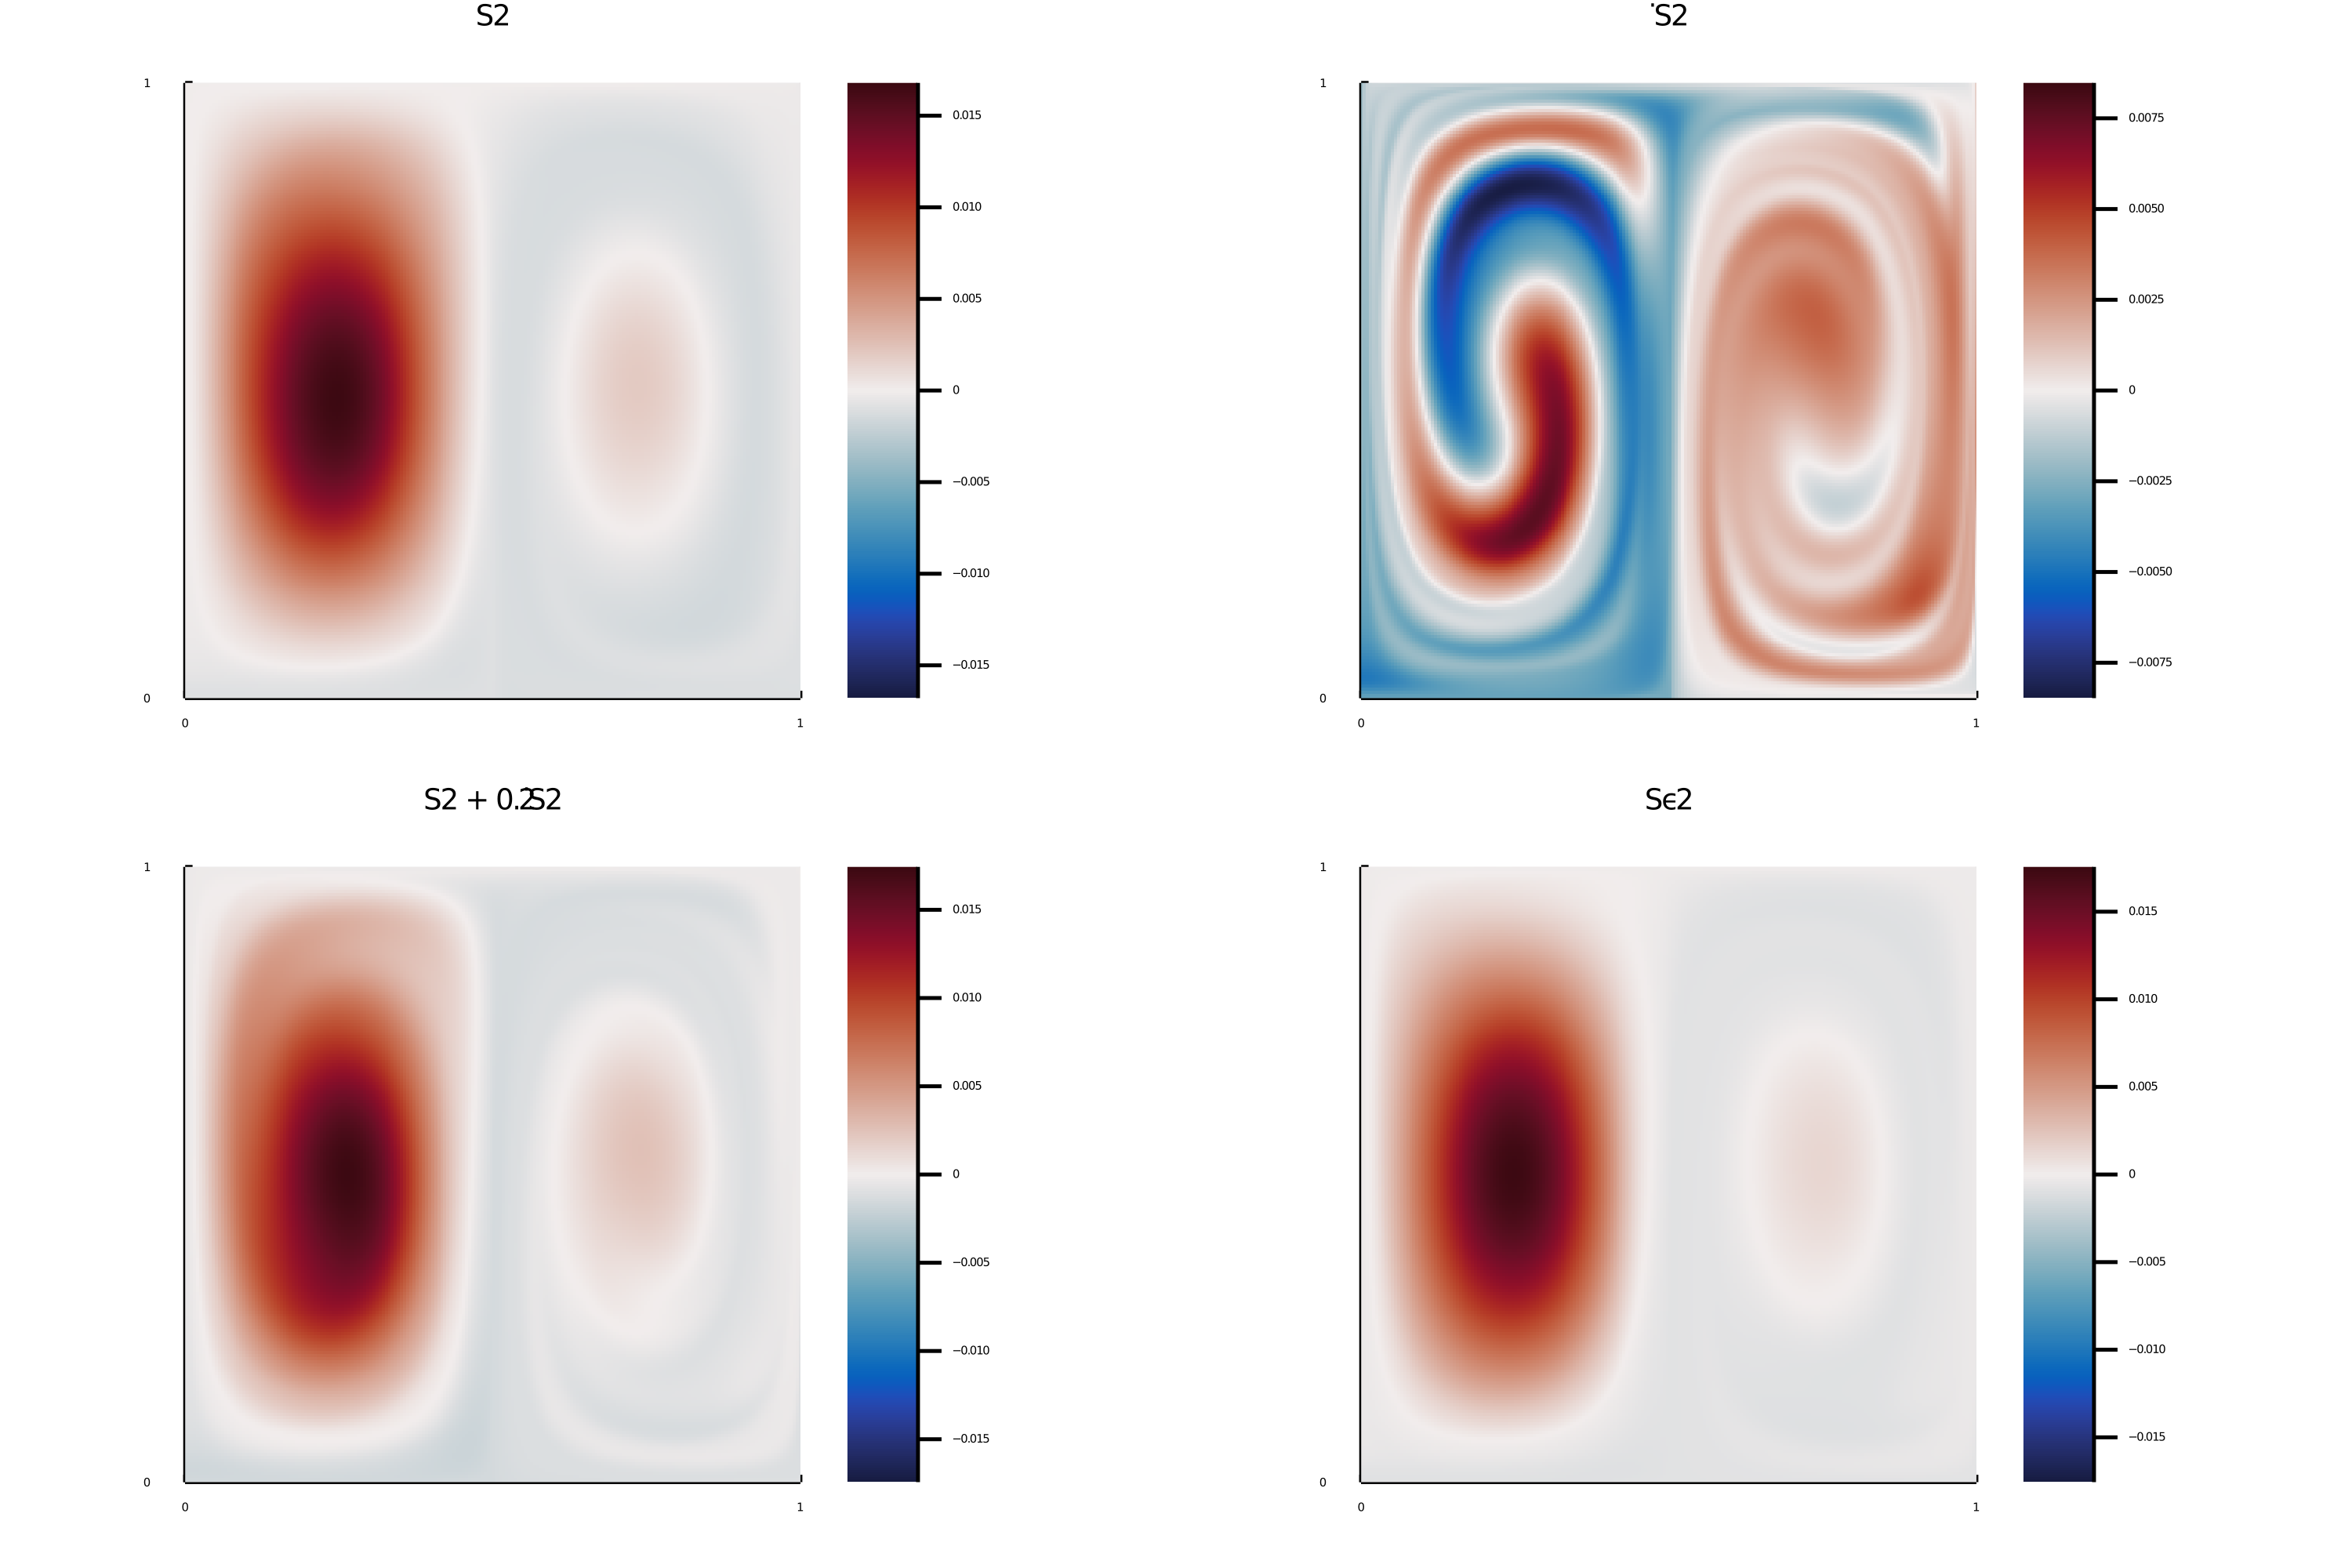

In [39]:
plots = []
push!(plots,plot_u(ctx, S′[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,ev])),maximum(abs.(S′[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S_dot[:,ev],  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,ev])),maximum(abs.(S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S′[:,ev] + ϵ*S_dot[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S′[:,ev] + ϵ*S_dot[:,ev])),maximum(abs.(S′[:,ev] + ϵ*S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ′[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(Sϵ′[:,ev])),maximum(abs.(Sϵ′[:,ev]))),
            xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

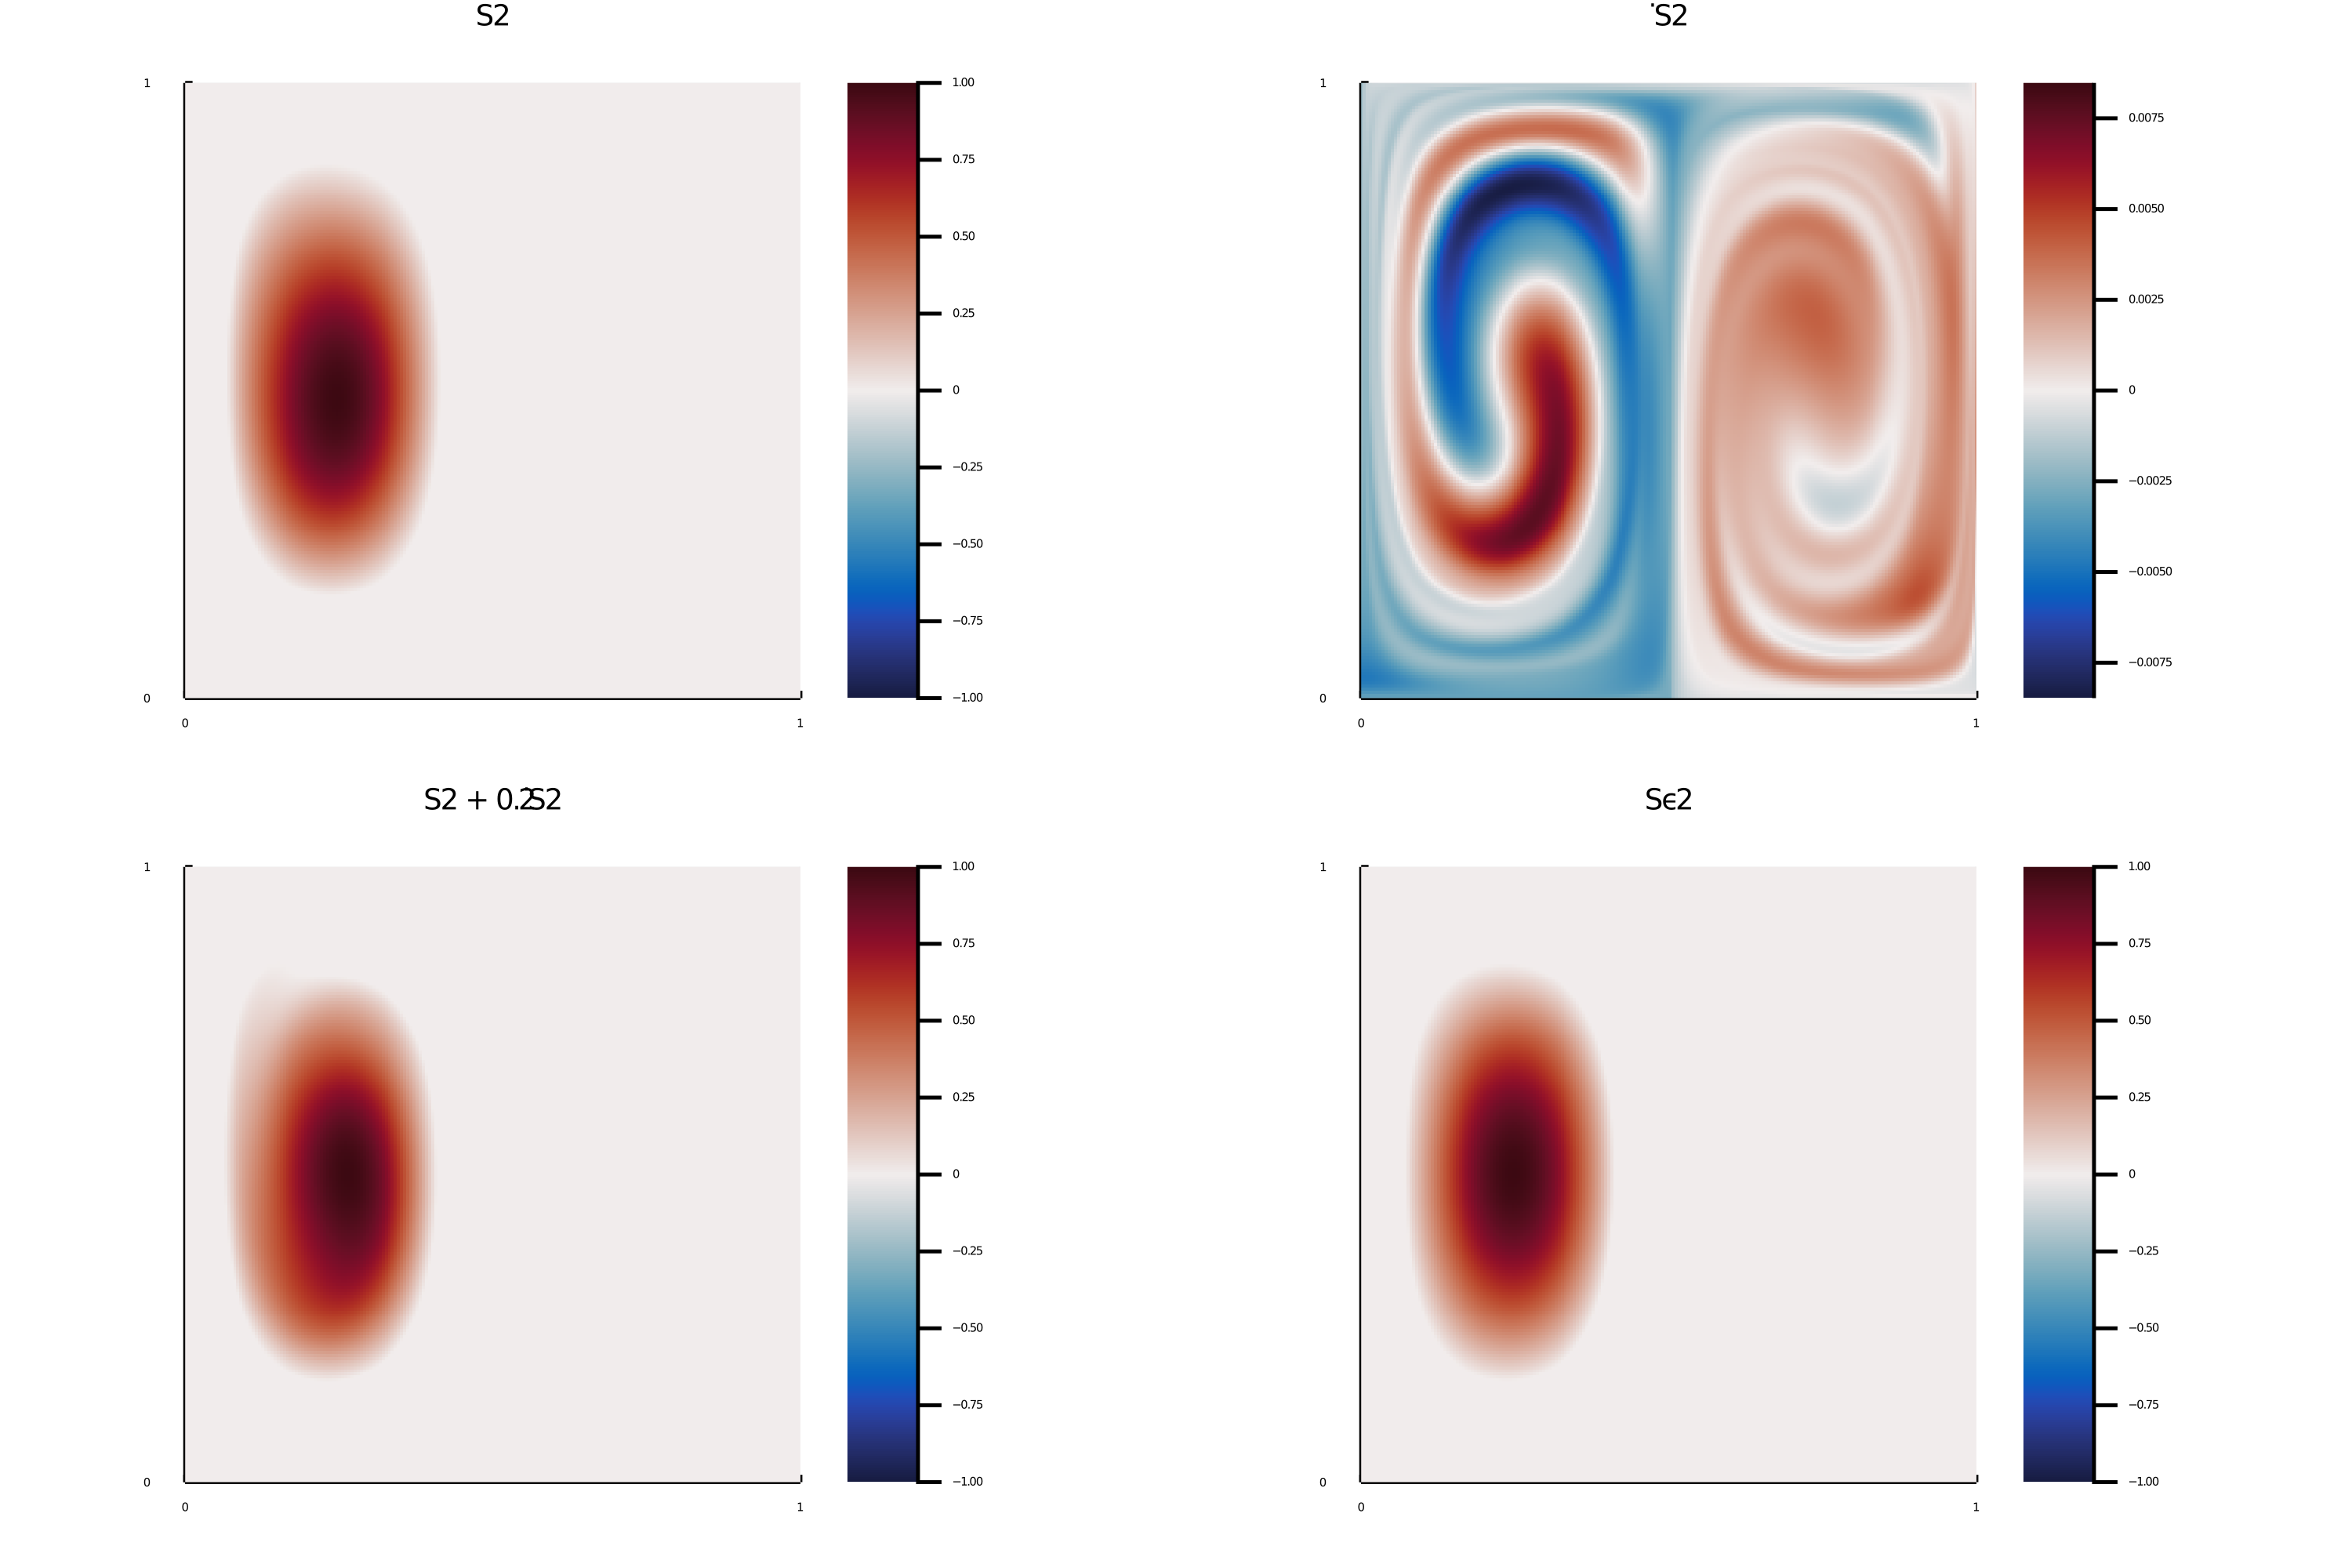

In [40]:
plots = []
push!(plots,plot_u(ctx, S[:,ev],  
        grid_resolution, grid_resolution, 
        title="S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, S_dot[:,ev],  
        grid_resolution, grid_resolution, 
        title="̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-maximum(abs.(S_dot[:,ev])),maximum(abs.(S_dot[:,ev]))),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),  
        grid_resolution, grid_resolution, 
        title="S"*string(ev)*" + $(ϵ)̇S"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
push!(plots,plot_u(ctx, Sϵ[:,ev],  
        grid_resolution, grid_resolution, 
        title="Sϵ"*string(ev), 
        colorbar=colorbar, color=color, clims=(-1,1),
            xticks=xticks, yticks=yticks))
Plots.plot(plots..., fmt=:png, dpi=500,layout=(2,2),
            xtickfontsize=2,ytickfontsize=2,xguidefontsize=2,yguidefontsize=2,legendfontsize=5,titlefontsize=5)

## Contourplots for SEBA

Levelsets are a better way to actually asses the quality of the predictions visually.

In [41]:
best_levelset, best_value = get_minimal_levelset(
    ctx,S[:,ev],dynamic_cheeger_value,
    n_candidates=1000,min=0)
c_best = level(best_levelset)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",c_best,"\n")

Dynamic Cheeger value:	8.45059467630079
Levelset:		0.02002002002002002


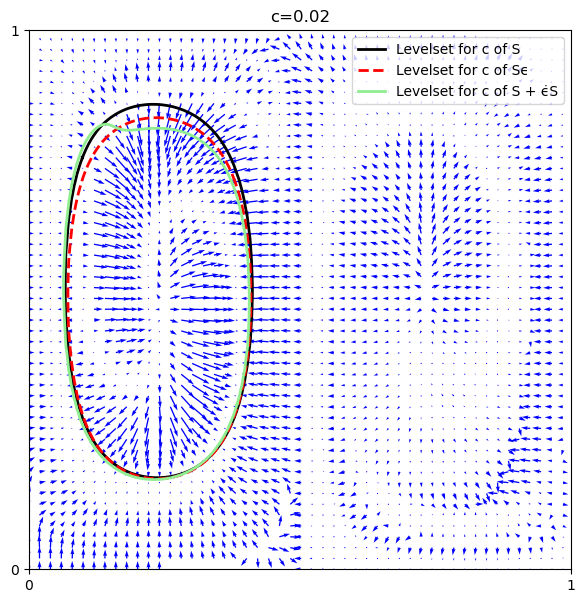

In [42]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,normalizeU(S′[:,ev]),S_dot[:,ev])...,ax,scale=0.2,step=4)
curves           = lines(get_levelset(ctx, S[:,ev],c_best))
curves_epsilon   = lines(get_levelset(ctx, Sϵ[:,ev],c_best))
curves_predicted = lines(get_levelset(ctx, normalizeU(softThreshold(S′[:,ev] + ϵ*S_dot[:,ev],μ)),c_best))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2, label="Levelset for c of S")
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2, label="Levelset for c of Sϵ")
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2, label="Levelset for c of S + ϵ̇S")
end
ax.set_title("c=$(round(c_best,digits=4))")
ax.legend(loc=1);